# Read in the data

In [1]:
import pandas as pd
import numpy
import re


data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

C:\Users\maod\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

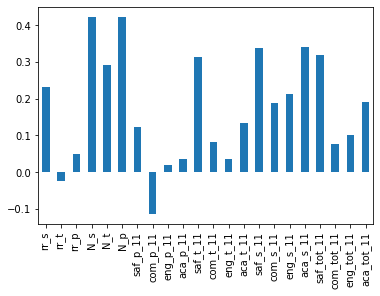

In [11]:
%matplotlib inline

sat_survey_correlation = correlations[survey_fields]

sat_survey_correlation.plot.bar()


There are high correlations between N_s, N_t, N_p and sat_score. These colunms are correlated with the number of respondents from students, teachers and parents. This makes sense that students, teachers and parents who are more proactive in respond to survey are more invested in education, which leads to higher sat_score. 

In addition, saf_t_11, saf_s_11 and saf_tot_11 correlate with sat_score. This shows students and teacher who feel safe in the teaching environment achieve better sat_score. Similarly school with a higher higher safety score get higher sat_score. This makes sense since people don't have to distract themselves worring about their safety in a safer environment.

aca_s_11 also correlate with sat_score, showing that students having higher academic expectations tend to have higher sat_score. However, this doesn't agrees with expecations from parents(aca_p_11) or teachers(aca_t_11). 

Next we will explore the safety at school further and figure out which schools have low safety scores.

### Explore Safety and SAT scores

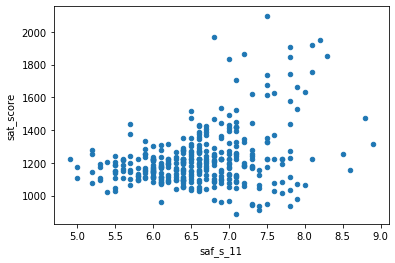

In [12]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

There are much more schools with high safety and SAT scores than those with low safety and SAT scores.
Schools with low safety and SAT socres also cluster together. This could be caused by the district the scools are in since the situation in each district can be very different. 

We will explore the average safety scores of each district next.

In [13]:
combined.groupby(by='boro').mean()['saf_s_11'].sort_values()

boro
Brooklyn         6.370755
Staten Island    6.530000
Bronx            6.606577
Queens           6.721875
Manhattan        6.831370
Name: saf_s_11, dtype: float64

It looks like Manhattan and Queens have higher safety scores, whereas Brooklyn has lower safety scores.

In [15]:
list(combined.columns)

['DBN',
 'SCHOOL NAME',
 'Num of SAT Test Takers',
 'SAT Critical Reading Avg. Score',
 'SAT Math Avg. Score',
 'SAT Writing Avg. Score',
 'sat_score',
 'SchoolName',
 'AP Test Takers ',
 'Total Exams Taken',
 'Number of Exams with scores 3 4 or 5',
 'Demographic',
 'School Name',
 'Cohort',
 'Total Cohort',
 'Total Grads - n',
 'Total Grads - % of cohort',
 'Total Regents - n',
 'Total Regents - % of cohort',
 'Total Regents - % of grads',
 'Advanced Regents - n',
 'Advanced Regents - % of cohort',
 'Advanced Regents - % of grads',
 'Regents w/o Advanced - n',
 'Regents w/o Advanced - % of cohort',
 'Regents w/o Advanced - % of grads',
 'Local - n',
 'Local - % of cohort',
 'Local - % of grads',
 'Still Enrolled - n',
 'Still Enrolled - % of cohort',
 'Dropped Out - n',
 'Dropped Out - % of cohort',
 'CSD',
 'NUMBER OF STUDENTS / SEATS FILLED',
 'NUMBER OF SECTIONS',
 'AVERAGE CLASS SIZE',
 'SIZE OF SMALLEST CLASS',
 'SIZE OF LARGEST CLASS',
 'SCHOOLWIDE PUPIL-TEACHER RATIO',
 'Name',

There are a few columns that indicate the percentage of each race at a given school:

* white_per
* asian_per
* black_per
* hispanic_per

By plotting out the correlations between these columns and sat_score, we can determine whether there are any racial differences in SAT performance.

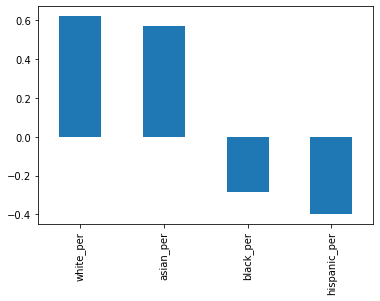

In [16]:
correlations[['white_per','asian_per','black_per','hispanic_per']].plot.bar()

The graphs shows that white and asian students have a positive correlation with the Sat_score, black and hispanic students have a negative correlation with the Sat_score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

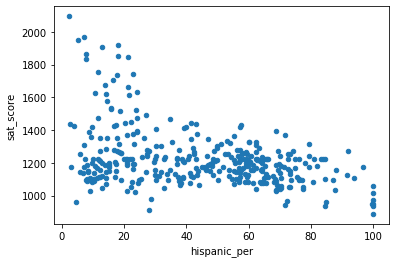

In [17]:
combined.plot.scatter(x='hispanic_per', y='sat_score')

Schools with higher sat_scores tend are more likely to have lower percentage of hispanic students. There are no schools showing high sat_scores whenthey have more than 30% hispanic students. In particularly, schools with over 90% hispanic students all show low sat_scores.

In [18]:
high_hisp_school = combined[combined['hispanic_per']> 95]

print(high_hisp_school['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Apart from having high percentages of hispanic students, these schools generally have a high percentage of students as English learners (between 67% and 84%). This probably explains why they have low sat_scores.

In [19]:
print(combined[(combined['hispanic_per']<10) & (combined['sat_score']>1800)]['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools have high percentage of asian and white students with no english learners. Earlier, we found that asian and white students correlates with sat_scores positively. In addition, these schools seem to be specialized science and technology that receive extra funding, and only admit students who pass an entrance exam. That means these students did well on a standardized test and they are more likely to do well in other standardized tests as well. 


### Exploring AP Scores vs. SAT Scores.

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship.

Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

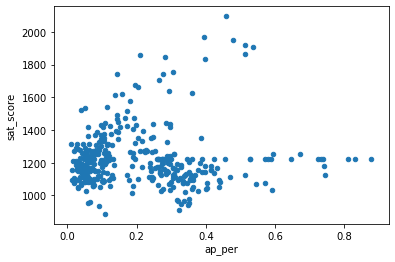

In [20]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined.plot.scatter(x='ap_per', y='sat_score')

It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. But it's not an extremely strong correlation.

Next we eeterming wheter there's a correlation between class size and SAT scores.

### Exploring Class Size vs SAT Scores. 

There are a few columns that indicate the class size at a given school:
 - 'AVERAGE CLASS SIZE',
 - 'SIZE OF SMALLEST CLASS'
 - 'SIZE OF LARGEST CLASS'
 
By plotting out the correlations between these columns and sat_score, we can determine whether there are any class size differences in SAT performance.


  

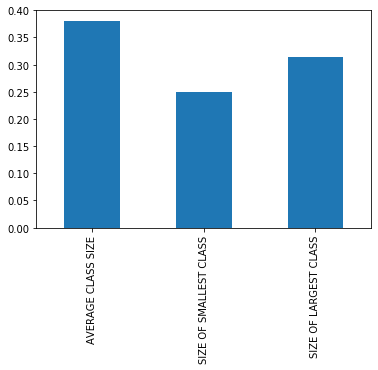

In [21]:
class_size = ['AVERAGE CLASS SIZE', 'SIZE OF SMALLEST CLASS', 'SIZE OF LARGEST CLASS']
correlations[class_size].plot.bar()

All three class size information correlates to the average SAT score. However, the average class size has a stronger correlation to the SAT score than the other two. The largetest class size has a stroner correlation to SAT score than the smallest class size. This suggest that having small class sizes do not always benefit students performance despite increased attention being paid to them. This could be because there are more students to learn from each other in a larger class.

Next we will explore the school locations to find out which neighborhoods have the best schools

### Exploring neighborhoods vs SAT Scores.


In [30]:
combined.groupby(by='zip').mean()['sat_score'].sort_values(ascending=False)

zip
10282    2096.000000
10021    1758.000000
10306    1615.000000
10031    1578.000000
11367    1576.500000
11433    1545.719403
11217    1545.500000
11364    1514.000000
11365    1474.000000
11210    1473.000000
11106    1449.333333
11361    1449.000000
11358    1441.000000
11230    1431.000000
10312    1418.000000
11694    1392.000000
10023    1378.000000
10010    1377.000000
10039    1374.000000
11366    1363.000000
11218    1352.000000
11229    1350.000000
11235    1345.666667
11416    1345.000000
10036    1338.000000
11220    1323.000000
10013    1321.000000
10301    1320.666667
11432    1318.073134
10011    1317.839659
            ...     
10016    1146.719403
11212    1143.500000
11236    1142.000000
10475    1142.000000
10451    1140.375000
10458    1139.666667
10457    1138.090909
11211    1136.714286
10467    1136.166667
11226    1135.200000
11691    1131.666667
11373    1131.333333
10459    1129.687761
11237    1127.000000
10027    1120.812935
11221    1118.487761
11203    

The negibourhoods with high SAT scores have the zip code of 10282, this corresponds to Battery Park City in Manhattan district